# e6 — Demand-Response (Fleet of Buildings): MF-PID GM→GM Scaling to d=10 zones

This notebook is **built from e5** (validated 1D DR MF vs IA) and generalizes the state dimension from **d=1** to **d=10**.

Interpretation: an **ensemble of buildings** (customers), each represented by a **d-zone state vector**.
- particle index k ↔ building k
- coordinate j ↔ zone j within a building

We keep the **same MF-PID workflow** as in e5:
1) specify GM initial/target distributions, 2) define PWC β protocol, 3) run MF fixed-point for ν(t),
4) simulate IA baselines and MF guidance using your `guided_continuous` API.

**Scaling demo goal:** show that the MF-vs-IA energy advantage and stable MF iteration persist in **d=10**.


In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch

HERE = Path().resolve()
ROOT = HERE.parents[1] if HERE.name == "test" else HERE.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from guided_continuous import (
    PWCProtocol, ContinuousCoeffs, GaussianMixture, GuidedField, TimeDomain,
)
from guided_continuous.shift_propagators import ShiftPropagators
from guided_continuous.shifted_field import ShiftedField
from guided_continuous.sde import (
    _build_break_aligned_grid, _make_break_set, _time_eval_right_limit,
)

device = torch.device("cpu")
dtype  = torch.float64
torch.set_default_dtype(dtype)

# ── Publication style ────────────────────────────────────────────────
plt.rcParams.update({
    'figure.dpi': 150,
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 11,
    'legend.fontsize': 8,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 1.8,
    'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
})

FIG_DIR = Path("figs/e6_mf_vs_ia_d10")
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("ROOT:", ROOT)

ROOT: /Users/chertkov/Dropbox/Apps/Overleaf/MeanField-PID/notebooks


## 1. Problem setup and simulation engine (d-dimensional generalization)
All dynamics and fields are exactly as in e5; only tensor shapes generalize from (B,1) to (B,d).

In [2]:

# ── Helpers ──────────────────────────────────────────────────────────
def cov_from_std_diag(s, d):
    """
    Build (K,d,d) diagonal covariances from per-component stds.
    s: (K,) or (K,d) tensor of stds
    """
    if s.ndim == 1:
        var = (s**2)[:, None].repeat(1, d)          # (K,d)
    else:
        var = s**2                                  # (K,d)
    cov = torch.diag_embed(var)                     # (K,d,d)
    return cov

def sample_gmm(gm, B, *, seed=0):
    """
    Sample X ~ GaussianMixture in R^d (supports full covs; we use diagonal here).
    Returns (B,d) and component labels (B,).
    """
    gen = torch.Generator(device=device); gen.manual_seed(int(seed))
    comp = torch.multinomial(gm.weights, B, replacement=True, generator=gen)   # (B,)
    means = gm.means[comp]                                                    # (B,d)
    covs  = gm.covs[comp]                                                     # (B,d,d)

    # For diagonal covs this is fast; for general covs we fallback to cholesky.
    # (Your GaussianMixture stores covs as (K,d,d).)
    # We detect diagonal by checking off-diagonal magnitude (cheap for our use).
    off = covs - torch.diag_embed(torch.diagonal(covs, dim1=-2, dim2=-1))
    if float(off.abs().max().item()) < 1e-14:
        std = torch.sqrt(torch.diagonal(covs, dim1=-2, dim2=-1))              # (B,d)
        eps = torch.randn((B, covs.shape[-1]), dtype=dtype, device=device, generator=gen)
        x = means + std * eps
    else:
        L = torch.linalg.cholesky(covs)                                       # (B,d,d)
        eps = torch.randn((B, covs.shape[-1]), dtype=dtype, device=device, generator=gen)
        x = means + torch.einsum("bij,bj->bi", L, eps)
    return x, comp

def gmm_pdf_1d(x, gm):
    """
    1D mixture pdf for plotting: gm is a GaussianMixture with means shape (K,1).
    """
    w = gm.weights.detach().cpu().numpy()
    m = gm.means.detach().cpu().numpy().reshape(-1)
    v = gm.covs.detach().cpu().numpy().reshape(-1)
    out = np.zeros_like(x, dtype=float)
    for k in range(len(w)):
        out += w[k]/np.sqrt(2*np.pi*v[k])*np.exp(-0.5*(x-m[k])**2/v[k])
    return out

def project_gm_to_1d(gm, v):
    """
    Project a GaussianMixture in R^d to 1D along direction v.
    Returns a 1D GaussianMixture with means shape (K,1) and covs shape (K,1,1).
    Handles gm.covs being either (K,d,d) or diagonal (K,d).
    """
    # make v shape (d,)
    v = v.reshape(-1)

    # means: (K,d) @ (d,) -> (K,)
    means_1d = (gm.means @ v).reshape(-1, 1)  # (K,1)

    covs = gm.covs
    if covs.ndim == 3:
        # full covs: (K,d,d)
        vars_1d = torch.einsum("i,kij,j->k", v, covs, v)  # (K,)
    elif covs.ndim == 2:
        # diagonal covs stored as (K,d)
        vars_1d = torch.sum(covs * (v**2)[None, :], dim=1)  # (K,)
    else:
        raise ValueError(f"Unexpected gm.covs shape: {tuple(covs.shape)}")

    covs_1d = vars_1d.reshape(-1, 1, 1)  # (K,1,1)

    return GaussianMixture(weights=gm.weights, means=means_1d, covs=covs_1d)


def build_field_and_shifted(nu_md, beta_v, breaks, gm_tar, td):
    """
    Same as e5, but ν is now (M,d) instead of (M,1).
    """
    nu_v = nu_md.to(dtype=dtype, device=device)
    bp = PWCProtocol(breaks=breaks, values=beta_v, time_domain=td)
    np_ = PWCProtocol(breaks=breaks, values=nu_v,  time_domain=td)
    co = ContinuousCoeffs(beta=bp, nu=np_, time_domain=td)
    gf = GuidedField(coeffs=co, target=gm_tar, time_domain=td)
    sp = ShiftPropagators(co)
    sf = ShiftedField(gf, sp)
    return gf, sf, co

print("Helpers ready (d-dimensional).")


Helpers ready (d-dimensional).


In [3]:

# ── Simulation engine (d-dim) ─────────────────────────────────────────
def simulate_ensemble(
    sf, z_batch, *, n_steps=2000, seed=0,
    return_trajectories=False, return_control_norms=False,
    record_drift_at=None,
):
    B, d = z_batch.shape
    x_tilde = torch.zeros((B, d), dtype=dtype, device=device)
    times = _build_break_aligned_grid(
        n_steps=n_steps, breaks=sf.coeffs.breaks,
        dtype=dtype, device=device, time_domain=sf.time_domain)
    bset = _make_break_set(sf.coeffs.breaks, dtype=dtype, device=device,
                           time_domain=sf.time_domain)
    dt_vec = times[1:] - times[:-1]

    if return_trajectories:
        traj = torch.empty((times.numel(), B, d), dtype=dtype, device=device)
        traj[0] = x_tilde + z_batch

    if return_control_norms:
        ctrl_sq = np.empty((times.numel()-1, B))

    drift_records = {}
    if record_drift_at is not None:
        rec_idx = {}
        for rt in record_drift_at:
            idx = int(torch.argmin(torch.abs(times - rt)).item())
            rec_idx[idx] = rt

    gen = torch.Generator(device=device); gen.manual_seed(int(seed))
    for i in range(times.numel()-1):
        t = times[i]; dt = dt_vec[i]
        t_eval = _time_eval_right_limit(t, bset, dtype=dtype, device=device,
                                        post_jump_eps=1e-12)
        drift = sf.u_star(t_eval, x_tilde, z_batch)              # (B,d)

        if return_control_norms:
            ctrl_sq[i] = (drift**2).sum(dim=-1).detach().cpu().numpy()

        if record_drift_at is not None and i in rec_idx:
            x_phys = (x_tilde + z_batch).detach().cpu().numpy()
            d_np   = drift.detach().cpu().numpy()
            drift_records[rec_idx[i]] = {'x': x_phys, 'drift': d_np}

        noise = torch.randn((B, d), dtype=dtype, device=device, generator=gen)
        x_tilde = x_tilde + drift * dt + torch.sqrt(dt) * noise

        if return_trajectories:
            traj[i+1] = x_tilde + z_batch

    result = {'times': times.detach().cpu().numpy(),
              'x_final': (x_tilde + z_batch).detach()}

    if return_trajectories:
        result['traj'] = traj.detach().cpu().numpy()

    if return_control_norms:
        result['ctrl_sq'] = ctrl_sq

    if record_drift_at is not None:
        result['drift_records'] = drift_records

    return result


def compute_empirical_mean_trajectory(
    sf, z_batch, eval_times, *, n_steps=2000, seed=0,
):
    B, d = z_batch.shape
    x_tilde = torch.zeros((B, d), dtype=dtype, device=device)
    times = _build_break_aligned_grid(
        n_steps=n_steps, breaks=sf.coeffs.breaks,
        dtype=dtype, device=device, time_domain=sf.time_domain)
    bset = _make_break_set(sf.coeffs.breaks, dtype=dtype, device=device,
                           time_domain=sf.time_domain)
    dt_vec = times[1:] - times[:-1]

    eval_idx = {}
    for et in eval_times:
        et_c = float(sf.time_domain.clamp(torch.tensor(et, dtype=dtype)).item())
        idx = int(torch.argmin(torch.abs(times - et_c)).item())
        eval_idx[idx] = et

    means = {}
    gen = torch.Generator(device=device); gen.manual_seed(int(seed))
    for i in range(times.numel()-1):
        if i in eval_idx:
            means[eval_idx[i]] = (x_tilde + z_batch).mean(dim=0).detach().cpu().numpy()  # (d,)
        t = times[i]; dt = dt_vec[i]
        t_eval = _time_eval_right_limit(t, bset, dtype=dtype, device=device,
                                        post_jump_eps=1e-12)
        drift = sf.u_star(t_eval, x_tilde, z_batch)
        noise = torch.randn((B, d), dtype=dtype, device=device, generator=gen)
        x_tilde = x_tilde + drift * dt + torch.sqrt(dt) * noise

    means[1.0] = (x_tilde + z_batch).mean(dim=0).detach().cpu().numpy()
    return means


def compute_control_metrics(res):
    ctrl_sq = res['ctrl_sq']; times = res['times']; dt = np.diff(times)
    pw = ctrl_sq.mean(axis=1)
    return 0.5*(times[:-1]+times[1:]), pw, np.cumsum(pw*dt)


def run_mf_iteration(gm_in, gm_tar, bv, brk, mids, td, *,
                     B=3000, n_steps=1200, zeta=0.50, max_iter=50,
                     init='nonlinear', amp=0.35, em_seed=777, ic_seed=100,
                     tol=2e-4):
    """
    Same MF fixed-point as e5, but ν(t) is now a d-vector per interval midpoint.
    """
    m_in_g  = (gm_in.weights[:, None]  * gm_in.means).sum(dim=0)   # (d,)
    m_tar_g = (gm_tar.weights[:, None] * gm_tar.means).sum(dim=0)  # (d,)

    MM = len(mids); d = gm_in.means.shape[1]

    # Linear reference protocol (used for reporting and as a baseline)
    nu_lin = torch.stack([m_in_g + (m_tar_g - m_in_g)*t for t in mids], dim=0)  # (M,d)

    # Initial guess for MF fixed-point iteration
    if init == 'linear':
        nu = nu_lin.clone()
    elif init == 'nonlinear':
        # Nonlinear perturbation around linear interpolation (same endpoints in expectation):
        #   ν^(0)(t) = ν^lin(t) + amp * sin(2π t) * (m_tar_g - m_in_g)
        # This intentionally injects curvature so we can test whether the MF map collapses back to linear.
        delta = (m_tar_g - m_in_g)
        nu = torch.stack([nu_lin[i] + float(amp)*math.sin(2.0*math.pi*float(mids[i]))*delta for i in range(MM)], dim=0)
    else:
        raise ValueError(f"Unknown init='{init}'. Use 'linear' or 'nonlinear'.")

    z0, _ = sample_gmm(gm_in, B, seed=ic_seed)

    h_nu=[nu.clone().cpu().numpy()]; h_d=[]
    for it in range(max_iter):
        _, sf, _ = build_field_and_shifted(nu, bv, brk, gm_tar, td)
        emp = compute_empirical_mean_trajectory(sf, z0, mids,
                                               n_steps=n_steps, seed=em_seed)
        nu_new = torch.stack([torch.tensor(emp[t], dtype=dtype, device=device) for t in mids], dim=0)  # (M,d)
        nu_upd = (1-zeta)*nu + zeta*nu_new
        delta = float(torch.max(torch.abs(nu_upd-nu)))
        h_d.append(delta); nu=nu_upd; h_nu.append(nu.clone().cpu().numpy())
        if (it+1)%5==0 or delta<tol:
            print(f"    {it+1:3d}: Δ={delta:.7f}")
        if delta<tol:
            print(f"    ✓ Converged ({it+1} iters)"); break
    else:
        print(f"    ⚠ {max_iter} iters, Δ={delta:.6f}")

    return nu, nu_lin, h_nu, h_d

print("Engine ready (d-dimensional).")


Engine ready (d-dimensional).


## 2. Distributions and protocol (fleet of buildings; each building has d zones)
We use a simple 2-component GM in $\mathbb{R}^d$:
- component 0: 'occupied' buildings, centered near comfort
- component 1: 'unoccupied/perimeter-heavy' buildings, offset in a subset of zones

All covariances are diagonal (per-zone independent noise) to make the high-d scaling clean.

In [17]:
import math
# ── Dimension (zones per building) ────────────────────────────────────
d = 10

# ── Fleet interpretation ──────────────────────────────────────────────
# Particles represent buildings/customers; each building state is a d-zone temperature deviation vector.
# Two GM components represent two coarse sub-populations in the fleet (e.g., different usage / envelope types).
#
# In this "overlap" experiment we deliberately make BOTH the initial and target mixtures:
#   - clearly bimodal, but with substantial overlap between the components (≈30–40%),
#   - structurally different across zones (perimeter vs interior) so the modes are not just shifted copies.
#
# Goal: test whether MF guidance still yields an (approximately) linear mean path when the modes overlap strongly.

# ── Distributions (GM→GM in R^d) ─────────────────────────────────────
pi_tar = torch.tensor([0.55, 0.45], dtype=dtype, device=device)   # desired fleet composition
pi_in  = torch.tensor([0.50, 0.50], dtype=dtype, device=device)   # post-event composition

# Zone groups (for structured heterogeneity)
perimeter = torch.arange(0, d//2, device=device)   # e.g. solar-exposed perimeter
interior  = torch.arange(d//2, d, device=device)   # interior zones

# Smooth zone-to-zone offsets (captures persistent heterogeneity in setpoints / loads)
zone_bias = 0.20*torch.sin(torch.linspace(0, 2.0*math.pi, d, dtype=dtype, device=device))

# -------------------------
# Target GM: desired comfort distribution (substantial overlap)
# -------------------------
# Mode 0: "cooler / tighter" but not extremely tight
m_tar0 = 0.10 * torch.ones(d, dtype=dtype, device=device) + 0.8*zone_bias
m_tar0[perimeter] += -0.15
m_tar0[interior]  +=  0.05

# Mode 1: "warmer / different structure" (perimeter noticeably warmer, interior only mildly warmer)
# Means are closer than in the previous notebook to enforce overlap.
m_tar1 = 0.70 * torch.ones(d, dtype=dtype, device=device) - 0.6*zone_bias
m_tar1[perimeter] +=  0.35
m_tar1[interior]  += -0.10

m_tar = torch.stack([m_tar0, m_tar1], dim=0)  # (2,d)

# Diagonal covariances: comparable scales -> overlap, but different structures
s_tar0 = 0.55 * torch.ones(d, dtype=dtype, device=device)
s_tar0[perimeter] = 0.65
s_tar0[interior]  = 0.45

s_tar1 = 0.70 * torch.ones(d, dtype=dtype, device=device)
s_tar1[perimeter] = 0.85
s_tar1[interior]  = 0.55

s_tar = torch.stack([s_tar0, s_tar1], dim=0)  # (2,d)
gm_tar = GaussianMixture(weights=pi_tar, means=m_tar, covs=cov_from_std_diag(s_tar, d))

# -------------------------
# Initial GM: post-curtailment distribution (visibly bimodal, still overlapping)
# -------------------------
# Construct initial modes as "warmer versions" of the target modes, with additional structural differences.
# This keeps the interpretation clear (recovery from a curtailment-induced temperature rise) while ensuring
# the initial marginal is distinctly bimodal (like the target).

# Warm-up offsets (global) + structured offsets (perimeter vs interior)
warm0, warm1 = 0.85, 1.15

m_in0 = m_tar0 + warm0 + 0.15*zone_bias
m_in0[perimeter] += 0.20
m_in0[interior]  += 0.05

m_in1 = m_tar1 + warm1 - 0.10*zone_bias
m_in1[perimeter] += 0.05
m_in1[interior]  += 0.25

m_in = torch.stack([m_in0, m_in1], dim=0)  # (2,d)

# Initial spreads: reduced vs previous to make the bimodality visible in projections,
# but still large enough to keep ~30–40% overlap.
s_in0 = 0.70 * torch.ones(d, dtype=dtype, device=device)
s_in0[perimeter] = 0.80
s_in0[interior]  = 0.60

s_in1 = 0.75 * torch.ones(d, dtype=dtype, device=device)
s_in1[perimeter] = 0.90
s_in1[interior]  = 0.65

s_in = torch.stack([s_in0, s_in1], dim=0)  # (2,d)
gm_in = GaussianMixture(weights=pi_in, means=m_in, covs=cov_from_std_diag(s_in, d))


# Global mixture means (vectors in R^d) — used for "linear" guidance baseline
m_in_g  = (pi_in[:, None]*m_in).sum(dim=0)       # (d,)
m_tar_g = (pi_tar[:, None]*m_tar).sum(dim=0)     # (d,)

# ── Protocol (same as e5) ─────────────────────────────────────────────
td = TimeDomain(eps=1e-3)
M = 8
breaks = torch.linspace(0, 1, M+1, dtype=dtype, device=device)
mids   = [float(0.5*(breaks[i]+breaks[i+1])) for i in range(M)]

#beta_0, gamma = 12.0, 0.65
beta_0, gamma = 12.0, 1.
bv = torch.tensor([beta_0*gamma**i for i in range(M)], dtype=dtype, device=device)

print(f"d={d} zones per building; particles represent buildings.")
print("Target weights:", pi_tar.detach().cpu().numpy(), "Initial weights:", pi_in.detach().cpu().numpy())
print("Target component means (first 5 dims):"); print(m_tar[:, :min(5, d)])
print("Initial component means (first 5 dims):"); print(m_in[:, :min(5, d)])
print("Target std ranges:", float(s_tar.min().item()), "to", float(s_tar.max().item()))
print("Initial std ranges:", float(s_in.min().item()), "to", float(s_in.max().item()))
print(f"β: [{', '.join(f'{b:.2f}' for b in bv.tolist())}]")


d=10 zones per building; particles represent buildings.
Target weights: [0.55 0.45] Initial weights: [0.5 0.5]
Target component means (first 5 dims):
tensor([[-0.0500,  0.0528,  0.1076,  0.0886,  0.0047],
        [ 1.0500,  0.9729,  0.9318,  0.9461,  1.0090]])
Initial component means (first 5 dims):
tensor([[1.0000, 1.1221, 1.1871, 1.1645, 1.0650],
        [2.2500, 2.1600, 2.1121, 2.1288, 2.2021]])
Target std ranges: 0.45 to 0.85
Initial std ranges: 0.6 to 0.9
β: [12.00, 12.00, 12.00, 12.00, 12.00, 12.00, 12.00, 12.00]


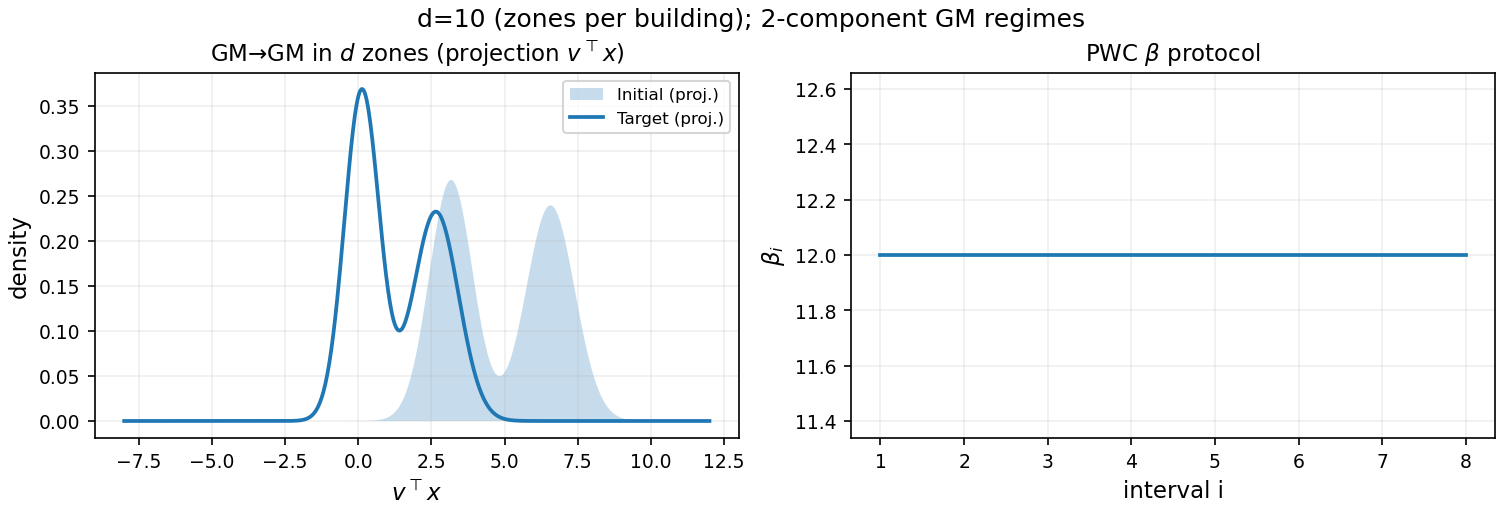

In [18]:

# ── Figure 1: projected GM densities + β protocol ─────────────────────
# Use discriminant direction v ∝ m_tar[1] - m_tar[0] for 1D visualization.
v = (m_tar[1] - m_tar[0])
v = v / torch.linalg.norm(v)

gm_in_1d  = project_gm_to_1d(gm_in, v)
gm_tar_1d = project_gm_to_1d(gm_tar, v)

xg = np.linspace(-8, 12, 600)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.2))

ax = axes[0]
ax.fill_between(xg, gmm_pdf_1d(xg, gm_in_1d),  alpha=0.25, label='Initial (proj.)')
ax.plot(xg, gmm_pdf_1d(xg, gm_tar_1d), '-', label='Target (proj.)')
ax.set_title(r"GM→GM in $d$ zones (projection $v^\top x$)")
ax.set_xlabel(r"$v^\top x$")
ax.set_ylabel("density")
ax.grid(alpha=0.2)
ax.legend()

ax = axes[1]
ax.step(range(1, M+1), bv.detach().cpu().numpy(), where='mid')
ax.set_xlabel("interval i")
ax.set_ylabel(r"$\beta_i$")
ax.set_title(r"PWC $\beta$ protocol")
ax.grid(alpha=0.2)

fig.suptitle(f"d={d} (zones per building); 2-component GM regimes", y=1.05)
fig.savefig(FIG_DIR / "e6_setup_proj_and_beta.png", dpi=300)
plt.show()


## 3. MF iteration and production simulations (d=10)
We run the same MF fixed-point iteration as e5, now for a vector-valued guidance trajectory \(\nu(t)\in\mathbb{R}^d\) per interval midpoint.

In [19]:

# ── MF fixed-point iteration ─────────────────────────────────────────
print("MF iteration (fixed EM seed=777):")
nu_mf, nu_lin, h_nu, h_delta = run_mf_iteration(
    gm_in, gm_tar, bv, breaks, mids, td,
    B=3000, n_steps=1200, init='nonlinear', amp=0.35, em_seed=777)

dev = nu_mf - nu_lin
print(f"max |ν^MF − linear| = {float(torch.max(torch.abs(dev))):.4f}")


MF iteration (fixed EM seed=777):
      5: Δ=0.0239122
     10: Δ=0.0027140
     15: Δ=0.0004090
     18: Δ=0.0001526
    ✓ Converged (18 iters)
max |ν^MF − linear| = 0.0444


In [20]:

# ── Build fields and simulate (same baselines as e5) ──────────────────
def _sf(nu_v):
    _, sf, _ = build_field_and_shifted(nu_v, bv, breaks, gm_tar, td)
    return sf

# IA baselines: ν=0 vector, and ν=global target mean vector (constant over time)
sf_ia0 = _sf(torch.zeros((M, d), dtype=dtype, device=device))
sf_iat = _sf(m_tar_g.reshape(1, d).repeat(M, 1))
sf_mf  = _sf(nu_mf)

# IA baseline: linear ν(t) interpolating between global initial mean and global target mean
nu_ialin = torch.stack([(1.0 - float(t))*m_in_g + float(t)*m_tar_g for t in mids], dim=0)  # (M,d)
sf_ialin = _sf(nu_ialin)


B_sim = 3000
N_SIM = 1500
z0, lab = sample_gmm(gm_in, B_sim, seed=42)
lab_np = lab.detach().cpu().numpy()

methods = [
    (sf_ia0,   r'IA(0)'),
    (sf_iat,   r'IA(tar)'),
    (sf_ialin, r'IA(lin)'),
    (sf_mf,    r'MF'),
]
ll = [l for _, l in methods]

res = {}
for sf, label in methods:
    print(f"  {label}...", end=' ')
    r = simulate_ensemble(sf, z0, n_steps=N_SIM, seed=7,
                          return_trajectories=True, return_control_norms=True)
    xf = r['x_final'].detach().cpu().numpy()
    # report fleet mean averaged over zones for a scalar summary
    print(f"mean_zones(E[x₁])={xf.mean():.3f}")
    res[label] = r

met = {l: compute_control_metrics(res[l]) for l in ll}
E_vals = {l: met[l][2][-1] for l in ll}
print(f"\nE(1): {', '.join(f'{l}={E_vals[l]:.2f}' for l in ll)}")
print(f"MF/IA(ν=0) = {E_vals[ll[2]]/E_vals[ll[0]]:.3f}")


  IA(0)... mean_zones(E[x₁])=0.407
mean_zones(E[x₁])=0.409
mean_zones(E[x₁])=0.410
mean_zones(E[x₁])=0.410

E(1): IA(0)=67.65, IA(tar)=51.44, IA(lin)=40.80, MF=40.81
MF/IA(ν=0) = 0.603


## 4. Figures: mean trajectory and energy (d=10)
We report (i) fleet mean averaged across zones, (ii) energy curves, and (iii) terminal projection match.
A heatmap of per-zone mean is also provided as a visually compelling high-d DR diagnostic.

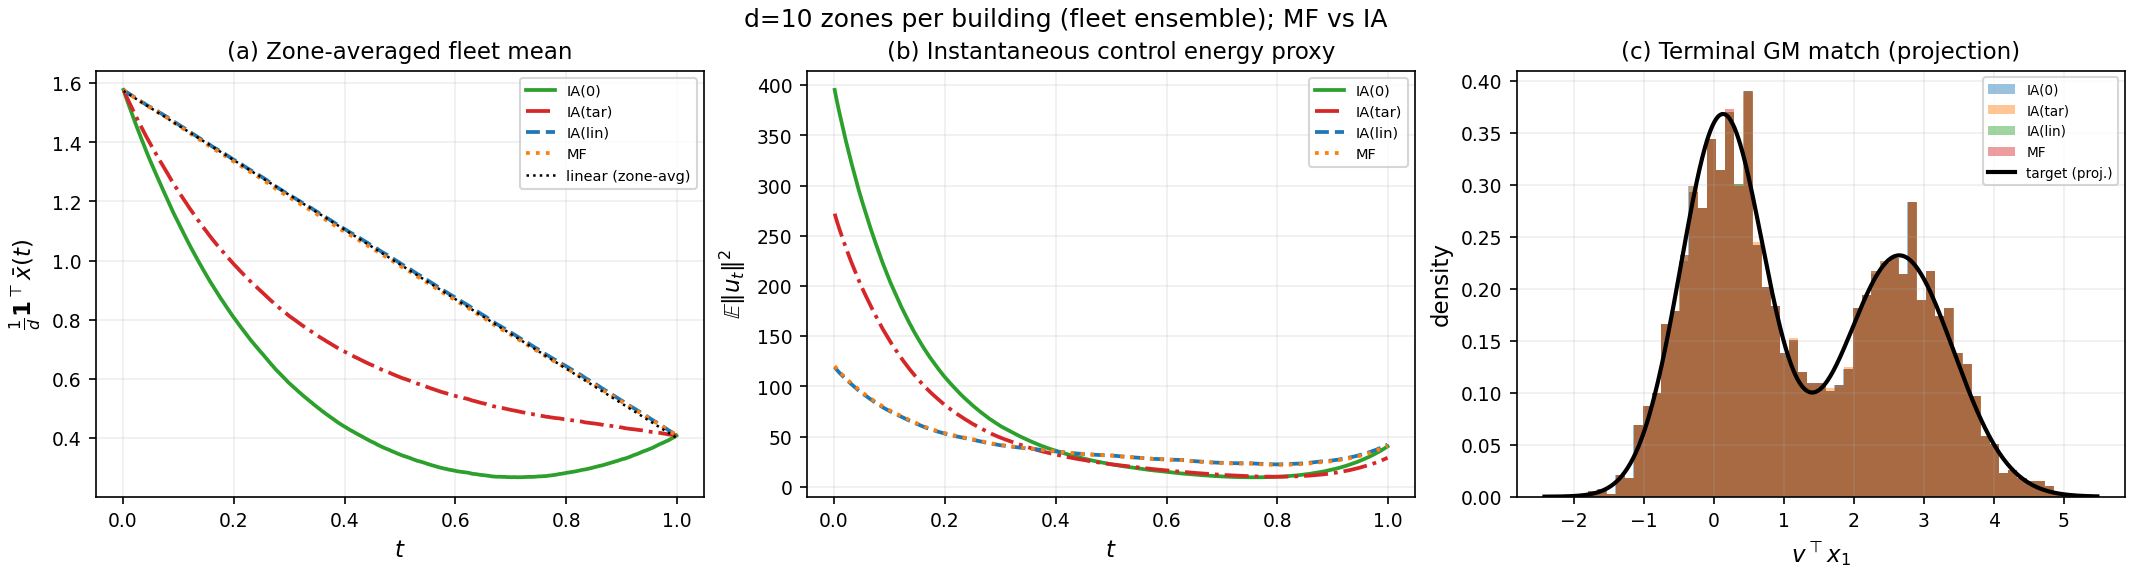

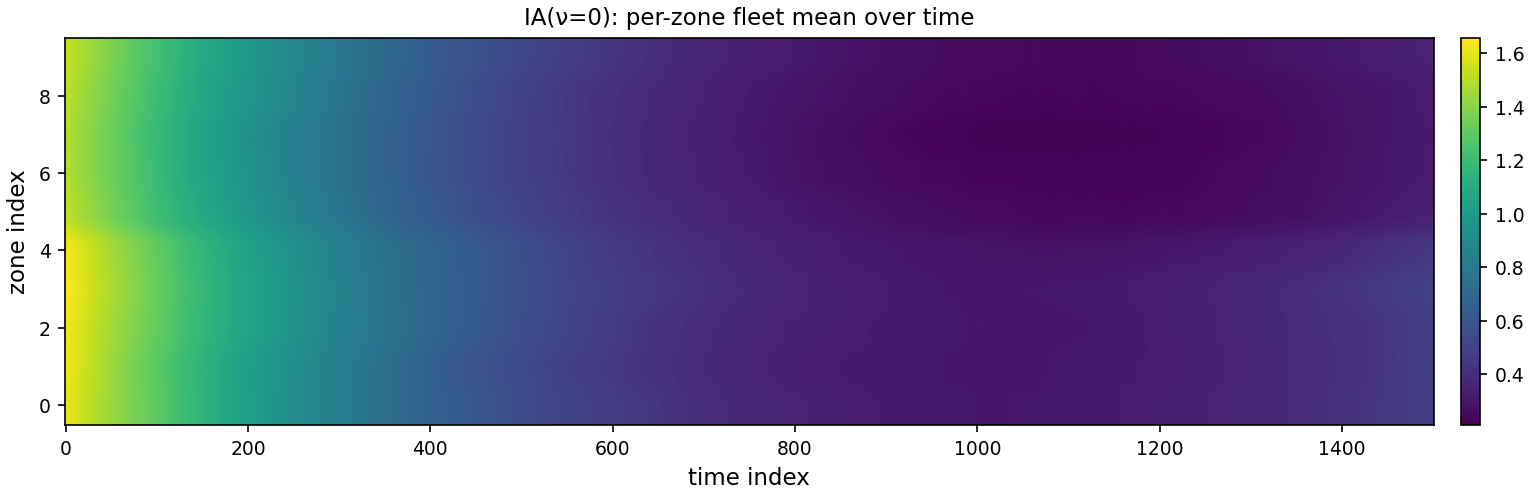

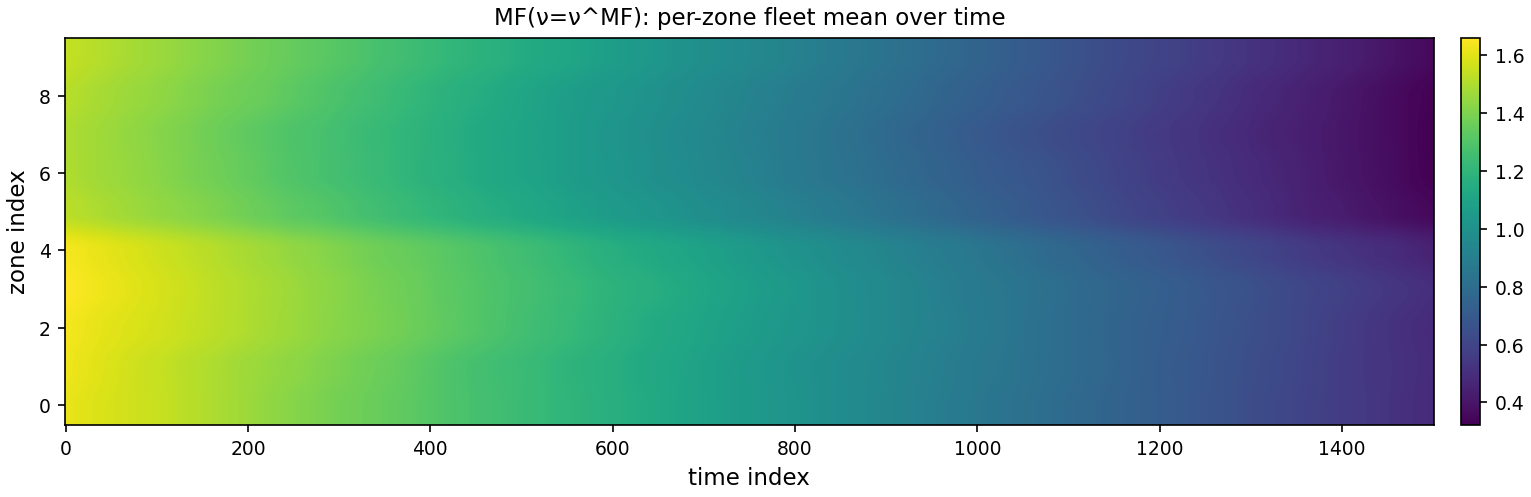

In [21]:

ls_m = {ll[0]: '-', ll[1]: '-.', ll[2]: '--'}
cm_m = {ll[0]: 'C2', ll[1]: 'C3', ll[2]: 'C0'}

# Discriminant direction for 1D projection plots
v = (m_tar[1] - m_tar[0]); v = v / torch.linalg.norm(v)
gm_tar_1d = project_gm_to_1d(gm_tar, v)

ls_m['MF'] = ':'
cm_m['MF'] = 'C1'

# ── Figure A: zone-avg mean + energy + terminal projection ────────────
fig, axes = plt.subplots(1, 3, figsize=(14.2, 3.6))

# (a) mean over buildings, then averaged over zones
ax = axes[0]
for l in ll:
    traj = res[l]['traj']                # (T,B,d)
    mean_t = traj.mean(axis=1).mean(axis=1)   # (T,)
    ax.plot(res[l]['times'], mean_t, ls=ls_m[l], color=cm_m[l], label=l)
t_ = res[ll[0]]['times']
mean_lin = (m_in_g.mean().item()) + ((m_tar_g.mean().item())-(m_in_g.mean().item()))*t_
ax.plot(t_, mean_lin, 'k:', lw=1.2, label='linear (zone-avg)')
ax.set_xlabel('$t$'); ax.set_ylabel(r'$\frac{1}{d}\mathbf{1}^\top \bar x(t)$')
ax.set_title('(a) Zone-averaged fleet mean')
ax.legend(fontsize=7); ax.grid(alpha=0.2)

# (b) instantaneous power proxy (mean ||u||^2)
ax = axes[1]
for l in ll:
    t_mid, pw, E = met[l]
    ax.plot(t_mid, pw, ls=ls_m[l], color=cm_m[l], label=l)
ax.set_xlabel('$t$'); ax.set_ylabel(r'$\mathbb{E}\|u_t\|^2$')
ax.set_title('(b) Instantaneous control energy proxy')
ax.legend(fontsize=7); ax.grid(alpha=0.2)

# (c) terminal projection histogram vs target marginal
ax = axes[2]
# terminal projected samples
for l in ll:
    xT = res[l]['x_final'].detach().cpu().numpy()           # (B,d)
    z = xT @ v.detach().cpu().numpy()                      # (B,)
    ax.hist(z, bins=55, density=True, alpha=0.45, label=l)
# target marginal
zg = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 600)
ax.plot(zg, gmm_pdf_1d(zg, gm_tar_1d), 'k-', lw=2.0, label='target (proj.)')
ax.set_xlabel(r'$v^\top x_1$'); ax.set_ylabel('density')
ax.set_title('(c) Terminal GM match (projection)')
ax.legend(fontsize=6.5); ax.grid(alpha=0.2)

fig.suptitle(f"d={d} zones per building (fleet ensemble); MF vs IA", y=1.05)
fig.savefig(FIG_DIR / "e6_main_scaling_fig.png", dpi=300)
plt.show()

# ── Figure B: heatmap of per-zone mean trajectory (MF and IA0) ─────────
def zone_mean_heatmap(label, title, fname):
    traj = res[label]['traj']                     # (T,B,d)
    mean_zone_time = traj.mean(axis=1).T          # (d,T)
    fig, ax = plt.subplots(1,1, figsize=(10.2, 3.3))
    im = ax.imshow(mean_zone_time, aspect='auto', origin='lower')
    ax.set_xlabel('time index'); ax.set_ylabel('zone index')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
    fig.savefig(FIG_DIR / fname, dpi=300)
    plt.show()

zone_mean_heatmap(ll[0], "IA(ν=0): per-zone fleet mean over time", "e6_heatmap_IA0.png")
zone_mean_heatmap(ll[2], "MF(ν=ν^MF): per-zone fleet mean over time", "e6_heatmap_MF.png")


AUC settings: compliance bands (c_occ=2.5, c_rel=3.0), zone-fraction threshold q=0.8; early horizon tau=0.5.
IA(0)                         AUC_viol=0.0045  AUC_viol(0,0.5)=0.0045  E=67.650  peak=395.360
IA(tar)                       AUC_viol=0.0052  AUC_viol(0,0.5)=0.0052  E=51.437  peak=272.009
IA(lin)                       AUC_viol=0.0086  AUC_viol(0,0.5)=0.0086  E=40.795  peak=119.184
MF                            AUC_viol=0.0085  AUC_viol(0,0.5)=0.0085  E=40.810  peak=120.289


/var/folders/s5/8pby83n5305c0l0dvb7d7p5c0000gr/T/ipykernel_77853/4094027462.py:160: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Saved: figs/e6_mf_vs_ia_d10/fig_compliance_power_auc.png


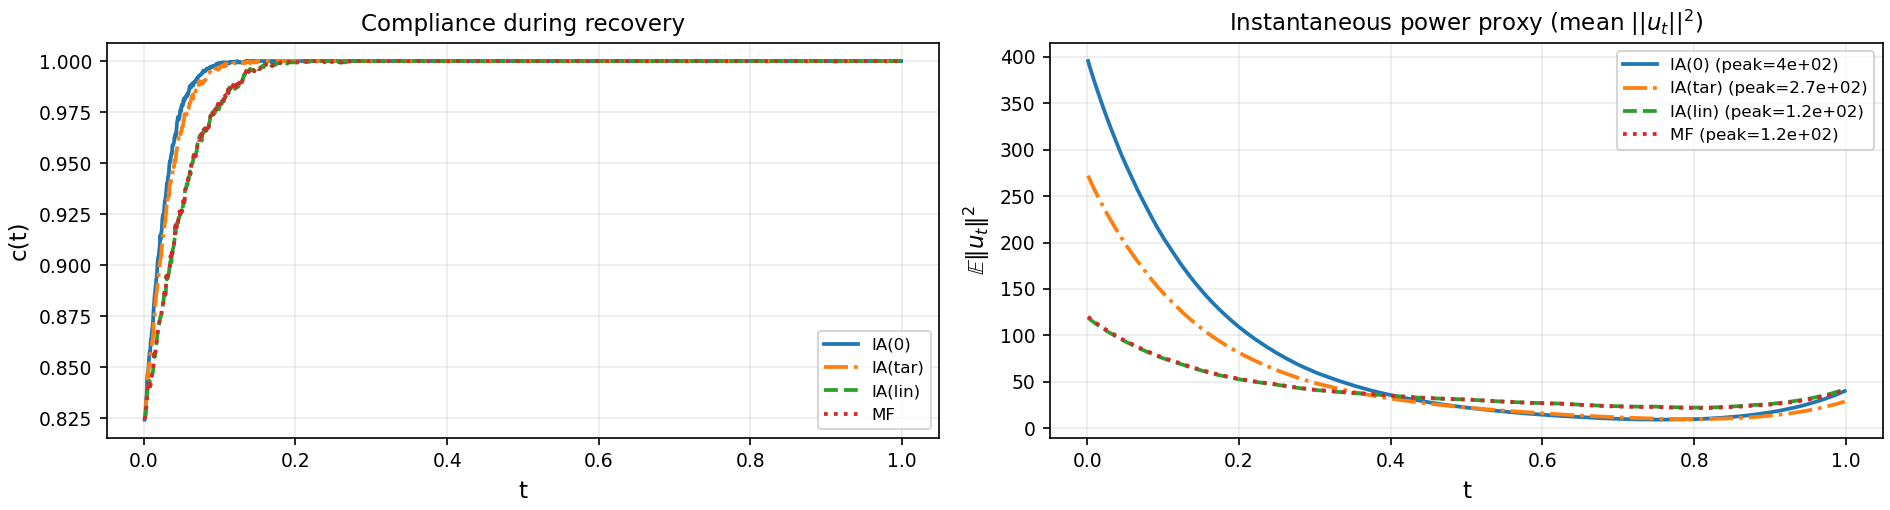

Saved: figs/e6_mf_vs_ia_d10/fig_nu_mf_minus_linear_heatmap.png


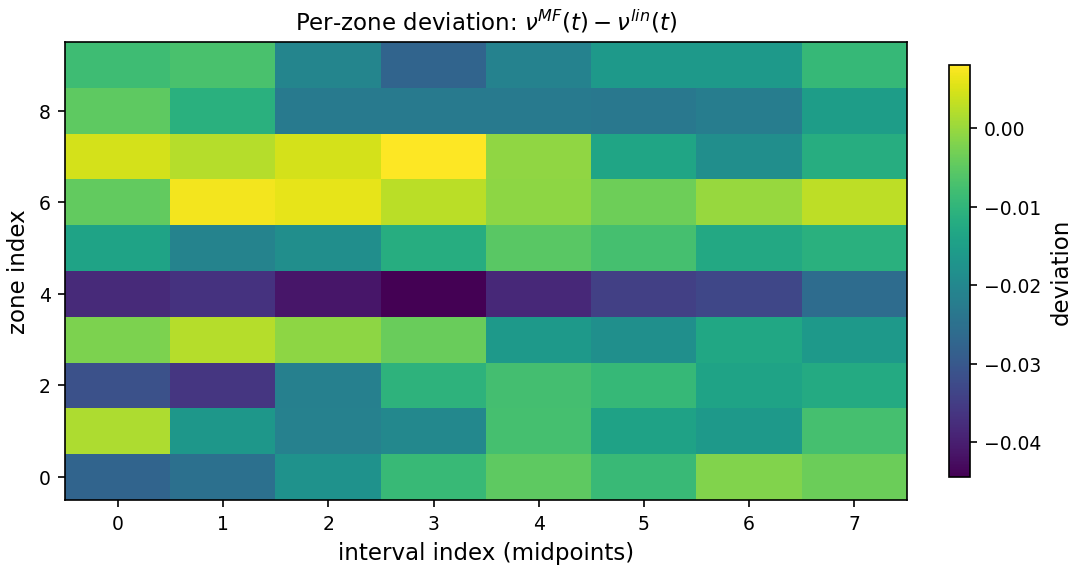

In [22]:
# ── Transition diagnostics (Torch-only) ───────────────────────────────
# We avoid endpoint-only checks. Instead:
#   - compliance curve c(t) during recovery
#   - AUC_violation = ∫ (1 - c(t)) dt, and early-horizon version up to τ
#   - instantaneous power proxy from ctrl_sq (mean ||u||^2), peak power, and energy proxy
#   - per-zone deviation of ν^MF(t) from the linear ν(t) baseline

import math
import torch
import matplotlib.pyplot as plt

# ---- helpers ----
def _to_torch(x, *, device=None, dtype=None):
    if torch.is_tensor(x):
        out = x
    else:
        out = torch.as_tensor(x)
    if dtype is not None:
        out = out.to(dtype)
    if device is not None:
        out = out.to(device)
    return out

# Ensure required arrays are torch tensors
for l in ll:
    res[l]["times_t"] = _to_torch(res[l]["times"], device=device, dtype=dtype)        # (T,)
    res[l]["traj_t"]  = _to_torch(res[l]["traj"],  device=device, dtype=dtype)        # (T,B,d)
    if "ctrl_sq" in res[l]:
        res[l]["ctrl_sq_t"] = _to_torch(res[l]["ctrl_sq"], device=device, dtype=dtype)  # (T-1,B)

def component_logpdf_diag(x, means, vars_diag):
    # x:(N,d), means:(K,d), vars_diag:(K,d) -> (N,K)
    diff2 = (x[:, None, :] - means[None, :, :])**2
    log_det = torch.sum(torch.log(2.0 * math.pi * vars_diag), dim=1)  # (K,)
    quad = torch.sum(diff2 / vars_diag[None, :, :], dim=2)            # (N,K)
    return -0.5 * (quad + log_det[None, :])

@torch.no_grad()
def responsibilities_over_time(traj, gm_tar):
    T, B, d = traj.shape
    vars_diag = torch.diagonal(gm_tar.covs, dim1=-2, dim2=-1)         # (K,d)
    X = traj.reshape(T * B, d)
    logpdf = component_logpdf_diag(X, gm_tar.means, vars_diag)
    logw = torch.log(gm_tar.weights[None, :] + 1e-12) + logpdf
    logw = logw - torch.max(logw, dim=1, keepdim=True).values
    resp = torch.softmax(logw, dim=1).reshape(T, B, -1)               # (T,B,K)
    return resp.mean(dim=1)                                           # (T,K)

@torch.no_grad()
def compliance_over_time(traj, gm_tar, *, c_occ=2.5, c_rel=3.0, q=0.8):
    """Compliance curve c(t) in [0,1].

    Regime-specific comfort bands around component means:
      k=0 (occupied/tight): |x-m0| <= c_occ*s0
      k=1 (relaxed):        |x-m1| <= c_rel*s1

    For each building at each time, assign regime by max responsibility under the target GM,
    then compute fraction of zones within band; building is compliant if fraction >= q.
    """
    T, B, d = traj.shape
    vars_diag = torch.diagonal(gm_tar.covs, dim1=-2, dim2=-1)         # (K,d)
    stds = torch.sqrt(vars_diag)                                       # (K,d)

    X = traj.reshape(T * B, d)
    logpdf = component_logpdf_diag(X, gm_tar.means, vars_diag)
    logw = torch.log(gm_tar.weights[None, :] + 1e-12) + logpdf
    logw = logw - torch.max(logw, dim=1, keepdim=True).values
    resp = torch.softmax(logw, dim=1).reshape(T, B, -1)               # (T,B,K)
    k_hat = torch.argmax(resp, dim=2)                                  # (T,B)

    m0 = gm_tar.means[0][None, None, :]
    m1 = gm_tar.means[1][None, None, :]
    band0 = (c_occ * stds[0])[None, None, :]
    band1 = (c_rel * stds[1])[None, None, :]

    frac0 = (torch.abs(traj - m0) <= band0).float().mean(dim=2)        # (T,B)
    frac1 = (torch.abs(traj - m1) <= band1).float().mean(dim=2)        # (T,B)
    frac_ok = torch.where(k_hat == 0, frac0, frac1)                    # (T,B)

    compliant = (frac_ok >= q)                                          # (T,B)
    return compliant.float().mean(dim=1)                                # (T,)

def power_curve_from_ctrl_sq(ctrl_sq_t):
    # ctrl_sq_t: (T-1,B) -> u2:(T-1,)
    u2 = ctrl_sq_t.mean(dim=1)
    return u2, float(torch.max(u2).item())

def energy_proxy_from_ctrl_sq(t, ctrl_sq_t):
    # E = ∫ E||u||^2 dt using left Riemann sum aligned with ctrl_sq on intervals
    u2 = ctrl_sq_t.mean(dim=1)                                          # (T-1,)
    dt = t[1:] - t[:-1]                                                 # (T-1,)
    return float(torch.sum(u2 * dt).item())

def auc_violation(t, c_t):
    # AUC = ∫ (1-c(t)) dt using trapezoid on provided grid
    v = 1.0 - c_t
    dt = t[1:] - t[:-1]
    return float(torch.sum(0.5*(v[1:]+v[:-1]) * dt).item())

def auc_violation_until(t, c_t, tau=0.5):
    mask = (t <= tau)
    idx = torch.nonzero(mask, as_tuple=False).reshape(-1)
    if idx.numel() < 2:
        return float("nan")
    t2 = t[idx]; c2 = c_t[idx]
    return auc_violation(t2, c2)

# ---- compute curves and summarize ----
tau = 0.5
summary = {}
for l in ll:
    t = res[l]["times_t"]
    traj = res[l]["traj_t"]
    c_t = compliance_over_time(traj, gm_tar, c_occ=2.5, c_rel=3.0, q=0.8)  # (T,)
    AUC = auc_violation(t, c_t)
    AUC_early = auc_violation_until(t, c_t, tau=tau)

    if "ctrl_sq_t" in res[l]:
        E = energy_proxy_from_ctrl_sq(t, res[l]["ctrl_sq_t"])
        u2, peak = power_curve_from_ctrl_sq(res[l]["ctrl_sq_t"])
    else:
        E, peak = float("nan"), float("nan")
        u2 = None

    summary[l] = dict(AUC=AUC, AUC_early=AUC_early, E=E, peak=peak, c_t=c_t, u2=u2)

print(f"AUC settings: compliance bands (c_occ=2.5, c_rel=3.0), zone-fraction threshold q=0.8; early horizon tau={tau}.")
for l in ll:
    s = summary[l]
    print(f"{l:28s}  AUC_viol={s['AUC']:.4f}  AUC_viol(0,{tau})={s['AUC_early']:.4f}  E={s['E']:.3f}  peak={s['peak']:.3f}")

# ---- Figure 1: compliance(t) and power(t) ----
t0 = res[ll[0]]["times_t"]
t_list = t0.detach().cpu().tolist()

fig, axes = plt.subplots(1, 2, figsize=(12.8, 3.6))

# (a) compliance curve
ax = axes[0]
for l in ll:
    ax.plot(t_list, summary[l]["c_t"].detach().cpu().tolist(), ls_m[l], label=l)
ax.set_title("Compliance during recovery")
ax.set_xlabel("t")
ax.set_ylabel("c(t)")
ax.grid(alpha=0.25)
ax.legend(fontsize=8)

# (b) power curve (if available)
ax = axes[1]
for l in ll:
    if summary[l]["u2"] is None:
        continue
    ax.plot(t_list[:-1], summary[l]["u2"].detach().cpu().tolist(), ls_m[l], label=f"{l} (peak={summary[l]['peak']:.2g})")
ax.set_title("Instantaneous power proxy (mean $||u_t||^2$)")
ax.set_xlabel("t")
ax.set_ylabel(r"$\mathbb{E}\|u_t\|^2$")
ax.grid(alpha=0.25)
ax.legend(fontsize=8)

plt.tight_layout()
fname = f"{FIG_DIR}/fig_compliance_power_auc.png"
plt.savefig(fname, dpi=300, bbox_inches="tight")
print("Saved:", fname)
plt.show()

# ---- Figure: per-zone deviation of ν^MF(t) from linear ν(t) ----
dev = nu_mf - nu_ialin  # (M,d)

fig, ax = plt.subplots(figsize=(7.2, 3.8))  # no constrained_layout
im = ax.imshow(dev.detach().cpu().numpy().T, aspect="auto", origin="lower")
ax.set_title(r"Per-zone deviation: $\nu^{MF}(t)-\nu^{lin}(t)$")
ax.set_xlabel("interval index (midpoints)")
ax.set_ylabel("zone index")

cbar = fig.colorbar(im, ax=ax, shrink=0.9)
cbar.set_label("deviation")

fname = f"{FIG_DIR}/fig_nu_mf_minus_linear_heatmap.png"
fig.savefig(fname, dpi=300, bbox_inches="tight")  # bbox_inches tight replaces tight_layout
print("Saved:", fname)
plt.show()


## 8) Transition diagnostics and baselines (overlapping modes)

Since the terminal marginal at $t=1$ is enforced by construction in the guided (bridge) formulation, endpoint-only checks are not informative.  
We therefore evaluate **recovery quality during the transition** using:

1. **Compliance curve** $c(t)$: fraction of buildings that satisfy a regime-specific comfort band at time $t$ (with a per-building criterion based on the fraction of zones within band).
2. **AUC discomfort**: $\mathrm{AUC}_{\mathrm{viol}}=\int_0^1 (1-c(t))\,dt$ and an early-horizon version $\int_0^{\tau}(1-c(t))\,dt$ (e.g., $\tau=0.5$).
3. **Power/energy proxies** from the simulated control norms: instantaneous mean $\mathbb{E}\|u_t\|^2$, peak power, and energy proxy $E=\int_0^1 \mathbb{E}\|u_t\|^2\,dt$.

Baselines compared:
- **IA($\nu=0$)**,
- **IA($\nu=\bar m^{\mathrm{tar}}$)** (constant target global mean),
- **IA(linear $\nu(t)$)**: $\nu(t)$ linearly interpolates between the global mean at $t=0$ and $t=1$,
- **MF($\nu=\nu^{\mathrm{MF}}$)**.

Additionally, to understand why MF can look close to linear when averaging over zones, we visualize **per-zone** deviations between $\nu^{\mathrm{MF}}(t)$ and the linear baseline.


In [23]:
# ── Scalar summaries (Torch-only; transition-focused) ─────────────────
# Reports:
#   - deviation of ν^MF from linear ν(t) baseline (RMS, max)
#   - energy proxy and AUC violation metrics (already computed in 'summary')

def l2_rms(x):
    return float(torch.sqrt(torch.mean(x**2)).item())

dev = nu_mf - nu_ialin
print("ν deviation summaries (MF vs linear ν(t)):")
print("  max |ν^MF - ν^lin|:", float(torch.max(torch.abs(dev)).item()))
print("  RMS |ν^MF - ν^lin|:", l2_rms(dev))
print("  RMS |ν^MF|        :", l2_rms(nu_mf))
print("  RMS |ν^lin|       :", l2_rms(nu_ialin))

print("\nTransition summaries (from diagnostics cell):")
for l in ll:
    s = summary[l]
    print(f"{l:28s}  AUC_viol={s['AUC']:.4f}  AUC_early={s['AUC_early']:.4f}  E={s['E']:.3f}  peak={s['peak']:.3f}")


ν deviation summaries (MF vs linear ν(t)):
  max |ν^MF - ν^lin|: 0.0443628394193325
  RMS |ν^MF - ν^lin|: 0.01824415695095459
  RMS |ν^MF|        : 1.0316912672025251
  RMS |ν^lin|       : 1.044862036915091

Transition summaries (from diagnostics cell):
IA(0)                         AUC_viol=0.0045  AUC_early=0.0045  E=67.650  peak=395.360
IA(tar)                       AUC_viol=0.0052  AUC_early=0.0052  E=51.437  peak=272.009
IA(lin)                       AUC_viol=0.0086  AUC_early=0.0086  E=40.795  peak=119.184
MF                            AUC_viol=0.0085  AUC_early=0.0085  E=40.810  peak=120.289
